# Sistema de recomendación de películas: *filtrado colaborativo basado en items*

La finalidad del proyecto es diseñar un sistema de recomendación simple para una plataforma de streaming, de manera que mediante la introducción del ID del usuario el sistema sea capaz de recomendar 5 películas en función de sus preferencias anteriores.

El proyecto consta de las siguientes partes:

*   Carga de datos y análisis exploratorio
*   Construcción del sistema de recomendación y ejemplos de funcionamiento
*   Evaluación del rendimiento del sistema
*   Consideraciones finales




## 1. Carga de datos y análisis exploratorio
---




In [183]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split

In [184]:
# Carga de los datasets sobre películas y califaciones de usuarios
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [185]:
# Visualización preliminar del dataset "movies"
print(movies.head())
print(movies.shape)


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
(9742, 3)


In [186]:
# Visualización preliminar del dataset "ratings"
print(ratings.head())
print(ratings.shape)

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
(100836, 4)


In [187]:
# Búsqueda de valores faltantes
print(movies.isnull().sum())
print(ratings.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [188]:
# Búsqueda de instancias duplicadas
print(movies.duplicated().sum())
print(ratings.duplicated().sum())

0
0


In [189]:
# Conservamos las columnas "movieId" y "title" en "movies"
movies = movies[["movieId","title"]]

In [190]:
# Conservamos las columnas "userId", "movieId" y "rating" para el dataset "ratings"
ratings = ratings[["userId","movieId","rating"]]

In [191]:
# Redefinición de columnas
movies = movies.rename(columns={"movieId": "movie_id"})
ratings = ratings.rename(columns={"userId": "user_id", "movieId": "movie_id"})

In [192]:
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [193]:
ratings.head()

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


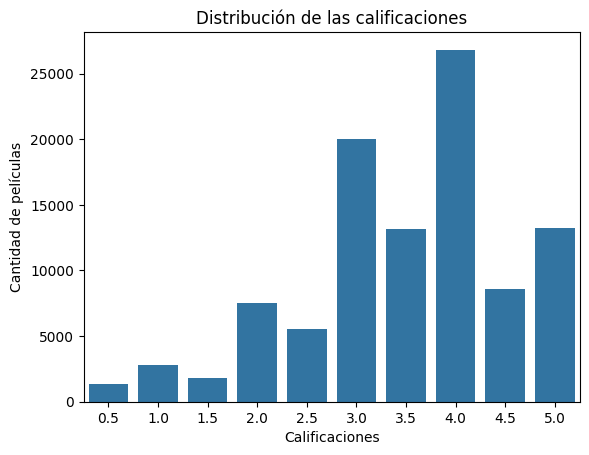

In [194]:
# Análisis mediante gráficos de correlaciones de interés

# Distribución de las calificaciones desde 0.5 a 5 estrellas (10 posibles calificaciones)
sns.countplot(data=ratings, x='rating')
plt.title('Distribución de las calificaciones')
plt.xlabel('Calificaciones')
plt.ylabel('Cantidad de películas')
plt.show()

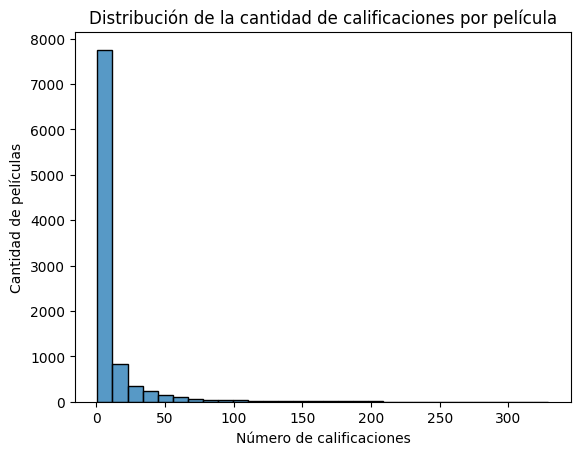

In [195]:
# Calificaciones por película
ratings_per_movie = ratings.groupby('movie_id').size()
sns.histplot(ratings_per_movie, bins=30)
plt.title('Distribución de la cantidad de calificaciones por película')
plt.xlabel('Número de calificaciones')
plt.ylabel('Cantidad de películas')
plt.show()

- Observamos como la distribucion de las calificaciones está sesgada, pues existen películas muy populares con muchas calificaciones en comparación con el resto. Esto puede llevar a que estas películas concretas sean más recomendadas que otras, a pesar de tener una calificación elevada.


In [196]:
# Calcular de cuántos usuarios disponemos
print(ratings['user_id'].nunique())
print(ratings['movie_id'].nunique())


610
9724


- Tenemos un total de 100836 calificaciones para 9724 películas de la plataforma, por parte de 610 usuarios.

In [197]:
# Analizamos la cantidad de califcaciones por usuario y ordenamos de forma descendente
ratings_per_user = (ratings.groupby('user_id')['movie_id'].count()).sort_values(ascending=False)
ratings_per_user

user_id
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: movie_id, Length: 610, dtype: int64

In [198]:
# Extraemos datos de interés mediante .describe()
ratings_per_user.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movie_id, dtype: float64

In [199]:
# Analizamos la cantidad de calificaciones por película y ordenamos de forma descendente
ratings_per_movie = ratings.groupby('movie_id').size()
ratings_per_movie.sort_values(ascending=False)

movie_id
356       329
318       317
296       307
593       279
2571      278
         ... 
4093        1
4089        1
58351       1
4083        1
193609      1
Length: 9724, dtype: int64

In [200]:
# Aplicamos .describe() a las calificaciones por pelicula
ratings_per_movie.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64

- Por un lado, podemos observar que un 50% de las películas que contiene nuestro dataset tienen únicamente 3 o menos calificaciones, lo que seguramente afectará negativamente a nuestro recomendador.
- Dado que es una cantidad muy elevada de películas, prescindiremos al menos de aquellas que sólo tengan 1 calificación (no sirven para hallar similaridad).
- Por otro lado, los usuarios como mínimo tienen 20 valoraciones, por lo que por ahora vamos a intentar no prescindir de más datos.


In [201]:
# Seleccionamos aquellas peliculas válidas, con al menos 2 valoraciones y menos de 100 (disminuir la influencia de las películas populares)
valid_movies = ratings_per_movie[(ratings_per_movie >= 2) & (ratings_per_movie <= 100)].index
ratings = ratings[ratings['movie_id'].isin(valid_movies)]
ratings_per_movie = ratings.groupby('movie_id').size()
ratings_per_movie

movie_id
3         52
4          7
5         49
7         54
8          8
          ..
187541     4
187593    12
187595     5
188301     3
189333     2
Length: 6144, dtype: int64

In [202]:
# Utilizamos .merge() para quedarnos con un único dataset "data" que incluya los títulos de las películas
data = pd.merge(movies, ratings, on='movie_id')
data.shape

(77602, 4)

In [203]:
data.head()

,movie_id,title,user_id,rating
0,3,Grumpier Old Men (1995),1,4.0
1,3,Grumpier Old Men (1995),6,5.0
2,3,Grumpier Old Men (1995),19,3.0
3,3,Grumpier Old Men (1995),32,3.0
4,3,Grumpier Old Men (1995),42,4.0


## 2. Construcción del sistema de recomendación y ejemplos de funcionamiento
---

In [204]:
# Creamos una pivot table (las columnas son los títulos de las películas y las filas los usuarios)

user_item_matrix = data.pivot_table(index='user_id', columns='title', values='rating')
# Rellenamos con 0 los valores NaN para evitar errores  (el sistema toma los 0 como película no calificada, no como puntuación baja)
user_item_matrix.fillna(0, inplace=True)
user_item_matrix

title,'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),...,Zoolander 2 (2016),Zootopia (2016),Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0


In [205]:
# Calculamos similitudes de items usando distancia de Pearson y creamos un df de similaridad a partir de las mismas
item_similarity = 1 - pairwise_distances(user_item_matrix.T, metric='correlation')
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [206]:
item_similarity_df

title,'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),...,Zoolander 2 (2016),Zootopia (2016),Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
'Round Midnight (1986),1.000000,-0.003196,0.170188,-0.014983,-0.006131,0.504041,-0.004511,-0.002824,-0.008636,-0.003847,...,-0.003986,-0.013228,-0.004527,-0.006506,-0.003981,-0.003295,-0.010881,-0.010979,-0.005096,-0.011605
'Til There Was You (1997),-0.003196,1.000000,-0.008811,-0.014534,-0.005948,-0.003844,0.550844,-0.002740,-0.008378,-0.003732,...,-0.003866,-0.012831,-0.004392,-0.006311,-0.003862,-0.003196,-0.010555,-0.010650,-0.004943,-0.011257
"'burbs, The (1989)",0.170188,-0.008811,1.000000,0.063054,0.235887,0.021495,-0.012437,-0.007786,-0.023808,-0.010606,...,-0.010988,0.003173,0.013911,-0.017935,-0.010976,-0.009083,0.187914,0.062128,-0.014048,0.353161
(500) Days of Summer (2009),-0.014983,-0.014534,0.063054,1.000000,0.133912,-0.018018,0.032067,0.088729,0.142418,0.112224,...,0.144336,0.215929,-0.020587,0.126107,0.061626,0.088707,0.053537,0.241031,0.139481,0.125830
*batteries not included (1987),-0.006131,-0.005948,0.235887,0.133912,1.000000,-0.007373,0.135676,0.273048,0.035571,-0.007159,...,0.123507,-0.024615,-0.008424,-0.012107,-0.007409,-0.006131,0.115367,-0.000094,-0.009483,0.234489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[REC]³ 3 Génesis (2012),-0.003295,-0.003196,-0.009083,0.088707,-0.006131,-0.003962,-0.004511,-0.002824,0.195614,-0.003847,...,-0.003986,0.277937,0.426259,0.542087,0.712378,1.000000,-0.010881,0.240384,0.227652,-0.011605
eXistenZ (1999),-0.010881,-0.010555,0.187914,0.053537,0.115367,0.085602,-0.014898,-0.009327,0.177808,0.166509,...,-0.013163,0.046817,0.065388,-0.021486,-0.013148,-0.010881,1.000000,0.162972,-0.016829,0.138557
xXx (2002),-0.010979,-0.010650,0.062128,0.241031,-0.000094,-0.013203,0.020658,0.059533,0.096595,0.299020,...,0.189427,0.200704,0.192137,0.291386,0.163448,0.240384,0.162972,1.000000,0.259031,0.065614


In [207]:
# Función de recomendación utilizando todo el conjunto de datos

def recommend_movies(user_id):
  # Establecemos una condición por si el usuario introducido no existe
    if user_id not in user_item_matrix.index:
        return "El usuario no existe en la base de datos."

    # Obtenemos las calificaciones del usuario y calculamos las puntuaciones de similitud
    user_ratings = user_item_matrix.loc[user_id]
    similar_scores = user_ratings.dot(item_similarity_df)

    # Calculamos los pesos totales y calculamos las puntuaciones finales evitando las divisiones entre cero
    sum_of_weights = np.abs(item_similarity_df).sum(axis=1)
    similar_scores = similar_scores / sum_of_weights.where(sum_of_weights != 0, 1)

    # Obtenemos las  5 mejores recomendaciones
    recommendations = similar_scores.sort_values(ascending=False).head(5)
    recommended_movie_names = recommendations.index

    return recommended_movie_names

In [208]:
# Diferentes ejemplos de uso de la función de recomendación

user_id = 129 # Por ejemplo, recomendar para el usuario con ID 129
print(f"Recomendaciones para el usuario {user_id}: {recommend_movies(user_id)}")

Recomendaciones para el usuario 129: Index(['Appleseed (Appurushîdo) (2004)', 'Gladiator (1992)',
       'Final Fantasy VII: Advent Children (2004)',
       '3 Ninjas Kick Back (1994)', 'Brave Little Toaster, The (1987)'],
      dtype='object', name='title')


In [209]:
user_id = 5
print(f"Recomendaciones para el usuario {user_id}: {recommend_movies(user_id)}")

Recomendaciones para el usuario 5: Index(['Widows' Peak (1994)',
       'Like Water for Chocolate (Como agua para chocolate) (1992)',
       'Before and After (1996)', 'Waiting to Exhale (1995)',
       'Dead Man Walking (1995)'],
      dtype='object', name='title')


In [210]:
user_id = 300
print(f"Recomendaciones para el usuario {user_id}: {recommend_movies(user_id)}")

Recomendaciones para el usuario 300: Index(['Before Midnight (2013)', 'Incendies (2010)', 'Intouchables (2011)',
       'Hunt, The (Jagten) (2012)', 'The Pacific (2010)'],
      dtype='object', name='title')


In [211]:
user_id = 1000
print(f"Recomendaciones para el usuario {user_id}: {recommend_movies(user_id)}")

Recomendaciones para el usuario 1000: El usuario no existe en la base de datos.


## 3. Evaluación del rendimiento del sistema
---

Evaluamos el rendimiento del sistema utilizando las métricas **precisión** y **exhaustividad** en un conjunto de prueba procedente del dataset completo, comparando las recomendaciones generadas con las películas relevantes para cada usuario.



In [212]:
# Dividimos en conjunto de entrenamiento y de test para raelizar correctamente la evaluación
train_data, test_data = train_test_split(data, test_size=0.2, random_state=63)

In [213]:
# Creamos 2 matrices de usuario-item para el conjunto de entrenamiento y para el de prueba
train_user_item_matrix = train_data.pivot_table(index='user_id', columns='title', values='rating')
train_user_item_matrix.fillna(0, inplace=True)
test_user_item_matrix = test_data.pivot_table(index='user_id', columns='title', values='rating')
test_user_item_matrix.fillna(0, inplace=True)

In [214]:
# Aseguramos de que las columnas en "train_user_item_matrix" y "test_user_item_matrix" sean las mismas
common_movies = train_user_item_matrix.columns.intersection(test_user_item_matrix.columns)
test_user_item_matrix = test_user_item_matrix[common_movies]

In [215]:
# Calculamos similitudes de items usando distancia de Pearson y creamos un df de similaridad a partir de las mismas
item_similarity_train = 1 - pairwise_distances(train_user_item_matrix.T, metric='correlation')
item_similarity_df_train = pd.DataFrame(item_similarity_train, index=train_user_item_matrix.columns, columns=train_user_item_matrix.columns)

In [216]:
# Función de recomendación utilizando el conjunto de entrenamiento (misma estructura que la anterior)
def recommend_movies_train(user_id):
    if user_id not in train_user_item_matrix.index:
        return "El usuario no existe en la base de datos."

    user_ratings = train_user_item_matrix.loc[user_id]
    similar_scores = user_ratings.dot(item_similarity_df_train)
    sum_of_weights = np.abs(item_similarity_df_train).sum(axis=1)
    similar_scores = similar_scores / sum_of_weights.where(sum_of_weights != 0, 1)

    recommendations = similar_scores.sort_values(ascending=False).head(5)
    recommended_movie_names = recommendations.index

    return recommended_movie_names

In [218]:
# Función de cálculo de precisión
def calculate_precision(test_user_item_matrix, recommend_movies_train, num_recommendations=5):
    total_recomendaciones_relevantes = 0
    total_recomendaciones = 0

    # Iteramos sobre cada usuario en la matriz de usuario-item de prueba
    for user_id in test_user_item_matrix.index:
        # Películas relevantes para el usuario en el conjunto de prueba
        peliculas_relevantes_usuario = test_user_item_matrix.loc[user_id].dropna().index.tolist()

        # Obtener recomendaciones para el usuario y contar las que coinciden con aqueñllas películas relevantes para el usuario
        recomendaciones_usuario = recommend_movies_train(user_id)
        recomendaciones_relevantes = [pelicula for pelicula in recomendaciones_usuario if pelicula in peliculas_relevantes_usuario]

        # Actualizar contadores
        total_recomendaciones_relevantes += len(recomendaciones_relevantes)
        total_recomendaciones += len(recomendaciones_usuario)

    # Calcular precisión
    precision = total_recomendaciones_relevantes / total_recomendaciones if total_recomendaciones > 0 else 0

    return precision

precision = calculate_precision(test_user_item_matrix, recommend_movies_train, num_recommendations=5)
print("Precisión:", round((precision), 3))

Precisión: 0.732


In [219]:
# Función de cálculo de recall/exhaustividad
def calculate_recall(test_user_item_matrix, recommend_movies_train):
    total_recomendaciones_relevantes = 0
    total_relevantes = 0

    # Iteramos sobre cada usuario en la matriz de usuario-item de prueba
    for user_id in test_user_item_matrix.index:
        # Películas relevantes para el usuario en el conjunto de prueba
        peliculas_relevantes_usuario = test_user_item_matrix.loc[user_id].dropna().index.tolist()

        # Obtener recomendaciones para el usuario
        recomendaciones_usuario = recommend_movies_train(user_id)

        # Contar recomendaciones relevantes
        recomendaciones_relevantes = [pelicula for pelicula in recomendaciones_usuario if pelicula in peliculas_relevantes_usuario]

        # Actualizar contadores
        total_recomendaciones_relevantes += len(recomendaciones_relevantes)
        total_relevantes += len(peliculas_relevantes_usuario)

    # Calcular exhaustividad (recall) (manejo de división por cero)
    exhaustividad = total_recomendaciones_relevantes / total_relevantes if total_relevantes > 0 else 0

    return exhaustividad

exhaustividad = calculate_recall(test_user_item_matrix, recommend_movies_train)
print("Exhaustividad:", exhaustividad)

Exhaustividad: 0.000848769245371972


## 4. Consideraciones finales
---

- El sistema de recomendación desarrollado muestra un buen desempeño en términos de precisión, pero necesita mejorar en términos de exhaustividad o recall.
- Se ha intentado mejorar la calidad de los datos reduciendo la cantidad de películas con poca valoraciones, reduciendo las calificaciones de aquellas películas más populares, entre otras decisiones. No obstante, parece que son otros factores los que están afectando al sistema de recomendación.


- **Posibles mejoras:**
1. Ampliar el conjunto de datos (posiblemente con más de 100000 ratings mejoraría la diversidad de las recomendaciones).

2. Utilizar otros algoritmos de filtrado colaborativo algo más complejo que el de "por items" que permitan más información para recomendar (por ejemplo, utilizar filtrado colaborativo "por contenido").

